In [51]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import constants as c
from astropy import units as u
import sys, os, glob
from astropy.io import fits
from matplotlib.patches import Ellipse

In [52]:
import treecorr
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [53]:
RA_range = (-4, 4)
Dec_range = (-4, 4)
num_den = 100
num_gal = int(np.abs(num_den * (Dec_range[1] - Dec_range[0]) * (RA_range[1] - RA_range[0])))
print(num_gal)

RAs = np.random.uniform(RA_range[0], RA_range[1], size=num_gal)
Decs = np.random.uniform(Dec_range[0], Dec_range[1], size=num_gal)

6400


In [54]:
def Q(x, y):
    return 4 * (d(x, y) + 4/3 * s(x, y)) * a(x, y) + 1/3 * c(x, y)**2
def S(x, y):
    return 2 * (d(x, y) + 4/3 * s(x, y)) ** 2 \
            + 2 * np.abs(a(x, y))**2 + 2/3 * np.abs(c(x, y))**2 + 4/9 * np.abs(s(x, y))**2
def gamma(x, y):
    return Q(x, y) / S(x, y)

def getLineParameters(xpos, ypos, gamma):
    length, angle = np.abs(gamma), np.angle(gamma)
    return [xpos - np.cos(angle)*length/2, xpos + np.cos(angle)*length/2], \
            [ypos - np.sin(angle)*length/2, ypos + np.sin(angle)*length/2]

In [55]:
d = np.vectorize(lambda x, y: 1e-1)
a_real, a_imag = np.vectorize(lambda x, y: 1e-2), np.vectorize(lambda x, y: np.sqrt(x**2+y**2) * 3e-3)
a = np.vectorize(lambda x, y: a_real(x, y) + a_imag(x, y) * 1j)
c_real, c_imag = np.vectorize(lambda x, y: 1e-2), np.vectorize(lambda x, y: np.sqrt(x**2+y**2) * 3e-3)
c = np.vectorize(lambda x, y: c_real(x, y) + c_imag(x, y) * 1j)
s = np.vectorize(lambda x, y: 1e-2)

In [56]:
gammas = gamma(RAs, Decs)
e_s = np.abs(gammas*2)
phi_s = np.angle(gammas*2)
a_ep_s = np.sqrt(S(RAs, Decs))
b_ep_s = a_ep_s * np.sqrt(1 - e_s**2)
print(a_ep_s.shape, b_ep_s.shape, e_s.shape, phi_s.shape, np.degrees(phi_s).shape)

(6400,) (6400,) (6400,) (6400,) (6400,)


(6400, 6)


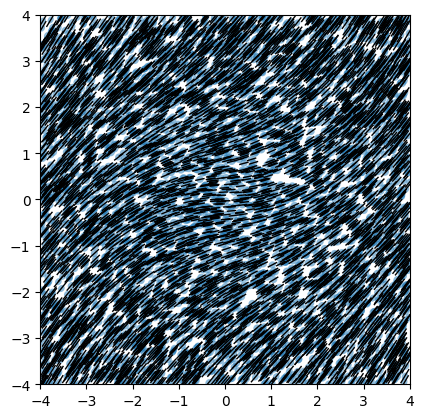

In [57]:
rand_coords = np.vstack((RAs, Decs, a_ep_s, b_ep_s, phi_s, gammas)).T
print(rand_coords.shape)

fig, ax = plt.subplots()
# Loop over the RA and Dec values
for ra, de, a_ep, b_ep, phi, gam in rand_coords:
    ra, de, a_ep, b_ep, phi = np.real([ra, de, a_ep, b_ep, phi])
    # Create an ellipse patch with a given size centered at the RA, Dec position
    plt.plot(*getLineParameters(ra, de, gam), color="black", lw=1)
    ellipse = Ellipse(xy=(ra, de), width=a_ep, height=b_ep, angle=np.degrees(phi), alpha=0.5)
    # Add the ellipse patch to the axes
    ax.add_patch(ellipse)

# Show the plot
ax.set_aspect('equal')
plt.xlim(RA_range)
plt.ylim(Dec_range)
plt.show()

In [58]:
print(RAs.shape, Decs.shape, gammas.shape)
print(RAs[0], Decs[0], gammas[0])

(6400,) (6400,) (6400,)
0.041532666220377656 1.8639778382483438 (0.1746794313375175+0.09864224688551206j)


# TreeCorr

In [59]:
cats = treecorr.Catalog(ra=RAs, dec=Decs, g1=np.real(gammas), g2=np.imag(gammas), \
                ra_units='deg', dec_units='deg')

In [60]:
rmin = 1
rmax = 10
nr = 3
out_dir = "out/20230105/"

In [61]:
narrow = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
              min_u=0.0, max_u=1, nubins=20,
              min_v=0.0, max_v=0.1, nvbins=1, verbose=2, output_dots=True)
wide = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
            min_u=0.9, max_u=1, nubins=1,
            min_v=0.0, max_v=0.8, nvbins=20, verbose=2, output_dots=True)
wider = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
             min_u=0.9, max_u=1, nubins=1,
             min_v=0.8, max_v=0.95, nvbins=20, verbose=2, output_dots=True)
widest = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
              min_u=0.9, max_u=1, nubins=1,
              min_v=0.95, max_v=1.0, nvbins=20, verbose=2, output_dots=True)

In [62]:
print("narrow")
ggg1 = treecorr.GGGCorrelation(narrow)
ggg1.process(cats, comm=comm)
ggg1.write(out_dir + 'narrow.hdf', write_patch_results=True)

print("wide")
ggg2 = treecorr.GGGCorrelation(wide)
ggg2.process(cats, comm=comm)
ggg2.write(out_dir + 'wide.hdf', write_patch_results=True)

print("wider")
ggg3 = treecorr.GGGCorrelation(wider)
ggg3.process(cats, comm=comm)
ggg3.write(out_dir + 'wider.hdf', write_patch_results=True)

print("widest")
ggg4 = treecorr.GGGCorrelation(widest)
ggg4.process(cats, comm=comm)
ggg4.write(out_dir + 'widest.hdf', write_patch_results=True)

narrow
r: nbins = 3, min,max sep = 1..10 arcmin, bin_size = 0.767528
u: nbins = 20, min,max = 0..1, bin_size = 0.05
v: nbins = 1, min,max = 0..0.1, bin_size = 0.1
Starting process GGG auto-correlations
Using 256 threads.
Building GField
Starting 1024 jobs.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# Plotting

In [63]:
plot_dir = "./figs/20230105/"

In [64]:
all_g_ttt = []
all_sig_ttt = []
all_meanr = []
all_phi = []

for ggg in [ggg1, ggg2, ggg3]:#, ggg4]:

    g_ttt = -0.25 * (ggg.gam0 + ggg.gam1 + ggg.gam2 + ggg.gam3).real
    var_ttt = 0.25**2 * (ggg.vargam0 + ggg.vargam1 + ggg.vargam2 + ggg.vargam3)

    _nr, nu, nv = g_ttt.shape
    print(nr,nu,nv)
    assert _nr == nr
    assert nv % 2 == 0
    nv //= 2
    assert nu == 1 or nv == 1

    d1 = ggg.meand1
    d2 = ggg.meand2
    d3 = ggg.meand3
    if nu == 1:
        # if nu==1, then u=1, so d2 = d3, and phi is between d2 and d3
        phi = np.arccos( (d2**2 + d3**2 - d1**2) / (2*d2*d3) )
        meanr = np.array([np.mean([d2[ir], d3[ir]]) for ir in range(nr)])
    else:
        # if nv==1, then v=0, so d1 = d2, and phi is between d1 and d2
        phi = np.arccos( (d1**2 + d2**2 - d3**2) / (2*d1*d2) )
        meanr = np.array([np.mean([d1[ir], d2[ir]]) for ir in range(nr)])
    phi *= 180/np.pi

    # We don't care about v>0 vs v<0, so combine them.
    phi = (phi[:,:,nv-1::-1] + phi[:,:,nv:]) / 2
    g_ttt = (g_ttt[:,:,nv-1::-1] + g_ttt[:,:,nv:]) / 2
    var_ttt = (var_ttt[:,:,nv-1::-1] + var_ttt[:,:,nv:]) / 4
    sig_ttt = var_ttt**0.5

    print('shapes:')
    print('phi: ',phi.shape)
    print('g_ttt: ',g_ttt.shape)
    print('sig_ttt: ',sig_ttt.shape)
    print('meanr: ',meanr.shape)

    print('meanr =  ',meanr)

    if nu == 1:
        phi = phi[:,0,:]
        g_ttt = g_ttt[:,0,:]
        sig_ttt = sig_ttt[:,0,:]
    else:
        phi = phi[:,:,0]
        g_ttt = g_ttt[:,:,0]
        sig_ttt = sig_ttt[:,:,0]

    print('shapes ->')
    print('phi: ',phi.shape)
    print('g_ttt: ',g_ttt.shape)
    print('sig_ttt: ',sig_ttt.shape)

    all_phi.append(phi)
    all_g_ttt.append(g_ttt)
    all_sig_ttt.append(sig_ttt)
    all_meanr.append(meanr)

3 20 2
shapes:
phi:  (3, 20, 1)
g_ttt:  (3, 20, 1)
sig_ttt:  (3, 20, 1)
meanr:  (3,)
meanr =   [1.55343782 3.79837249 8.34366438]
shapes ->
phi:  (3, 20)
g_ttt:  (3, 20)
sig_ttt:  (3, 20)
3 1 40
shapes:
phi:  (3, 1, 20)
g_ttt:  (3, 1, 20)
sig_ttt:  (3, 1, 20)
meanr:  (3,)
meanr =   [1.57354564 3.73174024 8.00960862]
shapes ->
phi:  (3, 20)
g_ttt:  (3, 20)
sig_ttt:  (3, 20)
3 1 40
shapes:
phi:  (3, 1, 20)
g_ttt:  (3, 1, 20)
sig_ttt:  (3, 1, 20)
meanr:  (3,)
meanr =   [1.52626274 3.70232937 8.05633219]
shapes ->
phi:  (3, 20)
g_ttt:  (3, 20)
sig_ttt:  (3, 20)


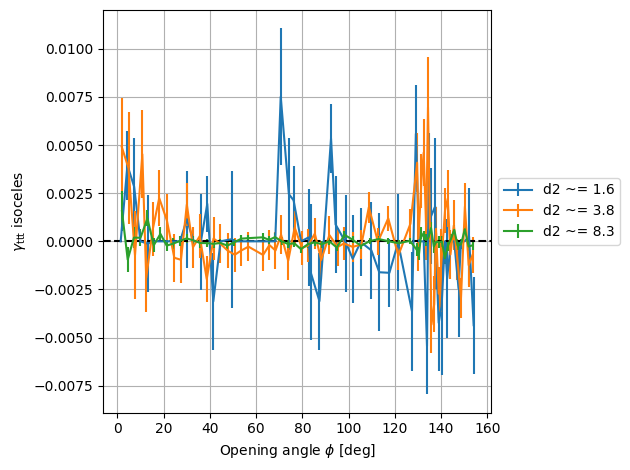

In [66]:
phi = np.concatenate(all_phi, axis=1)
g_ttt = np.concatenate(all_g_ttt, axis=1)
sig_ttt = np.concatenate(all_sig_ttt, axis=1)
meanr = np.concatenate(all_meanr, axis=0)

fig, ax = plt.subplots()

lines = []
for ir in range(nr):
    # print('ir = ',ir)
    # print('meanr = ',meanr[ir])
    # print('phi = ',phi[ir])
    # print('g = ',g_ttt[ir])
    # print('sig = ',sig_ttt[ir])
    # print()

    line = ax.errorbar(phi[ir], g_ttt[ir], sig_ttt[ir])
    lines.append((line, 'd2 ~= %.1f'%meanr[ir]))

ax.legend(*(list(zip(*lines))), loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(r'Opening angle $\phi$ [deg]')
ax.set_ylabel(r'$\gamma_{\rm ttt}$ isoceles')

fig.set_tight_layout(True)
ax.grid()
ax.axhline(y=0, ls="--", color="black")
# plt.savefig(plot_dir + '640gal_4x4deg.pdf')
# plt.savefig(plot_dir + '640gal_4x4deg.png')
plt.show()